In [1]:
import h5py
import numpy as np
import numba
import os
import pandas as pd
import unyt
import verdict

In [2]:
import matplotlib.colors
import palettable

In [3]:
import linefinder.analyze_data.worldlines as worldlines
import linefinder.analyze_data.plot_worldlines as plot_worldlines

In [4]:
import galaxy_dive.trends.galaxy as gal_trends  
import galaxy_dive.plot_data.plotting as plotting

# Load Cosmological History Data

In [5]:
w = worldlines.Worldlines(
    data_dir = '/scratch/03057/zhafen/linefinder_data/multiphysics/m12i_res7100_mhdcv/data',
    tag = 'm12imhdcv_clustersofFIRE_pop1',
    halo_data_dir = '/scratch/03057/zhafen/multiphysics/m12i_res7100_mhdcv/halo',
    main_halo_id = 0,
)

In [6]:
w_plotter = plot_worldlines.WorldlinesPlotter( w, )

# Load Cluster Data

In [7]:
data_dir = '/scratch/03057/zhafen/linefinder_data/multiphysics/m12i_res7100_mhdcv/data'
file_name = 'ClusterPopulation_1_reduced.hdf5'
file_path = os.path.join( data_dir, file_name )
f = h5py.File( file_path, 'r' )

In [8]:
# Format data
id_data = {}
for key in f.keys():
    if key == 'Coordinates':
        for i in range( 3 ):
            id_data['P{}'.format( i )] = f[key][...][:,i]
    elif key == 'TracerID':
        id_data[key] = f[key][...].astype( int )
    else:
        id_data[key] = f[key][...]

In [9]:
id_df = pd.DataFrame(
    data = id_data,
)
id_df = id_df.set_index( 'TracerID' )

# Correlate the Two Files

In [10]:
data_out = {}

In [11]:
# Set up a dataframe to find the relevant indices of the particle array
loc_df = pd.DataFrame(
    {
        'ID': w.get_data( 'ID' ).astype( int ),
        'inds': np.arange( w.get_data( 'ID' ).size ).astype( int )
    }
)
loc_df = loc_df.set_index( 'ID' )

In [12]:
# Get the ind_array to use for creating the file
ind_df = loc_df.reindex( id_df.index )
is_nan = np.isnan( ind_df['inds'] )
is_not_nan = np.invert( is_nan )
ind_arr = ind_df['inds'][is_not_nan].values.astype( int )

In [13]:
def format_worldlines_data_for_output( arr, shape=( id_df.index.size, w.n_snaps ) ):
    '''Format worldlines data to account for NaN values.'''
    
    output_arr = np.full( shape, np.nan )
    output_arr[is_not_nan] = arr

    return output_arr

# Store Specific Correlated Outputs

In [14]:
# Store the tracer IDs
data_out['TracerID'] = format_worldlines_data_for_output( w.get_data('ID')[ind_arr], shape=( id_df.index.size, ) )

In [15]:
# Assert that the IDs are stored in the expected order.
other_is_not_nan = np.invert( np.isnan( data_out['TracerID'] ) )
np.testing.assert_allclose( data_out['TracerID'][other_is_not_nan], id_df.index[other_is_not_nan] )

In [16]:
# Store a bunch of additional correlated data
for i, key in enumerate( [ 'R', 'M_enc', 'Txx', 'Tyy', 'Tzz', 'Txy', 'Tzx', 'Tyz', 'Vx', 'Vy', 'Vz', 'mt_gal_id' ] ):
    data_out[key] = format_worldlines_data_for_output( w.get_data( key )[ind_arr,:] )

In [17]:
# Get and store velocity dispersion interior to R
r = w.get_data( 'R' )
sigma = np.full( w.base_data_shape, fill_value=np.nan )
r_co = r * w.hubble_param * ( 1. + w.redshift )[np.newaxis,:] 

for i, snum in enumerate( w.snums ):
    
    if i % 100 == 0:
        print( snum )
    
    sigma[:,i] = w.halo_data.get_profile_data(
        'sigv',
        snum = snum,
        r = r_co[:,i],
        mt_halo_id = w.main_halo_id,
    )

data_out['SigmaV'] = format_worldlines_data_for_output( sigma[ind_arr,:] )

600
500
400
300
200
100


In [18]:
# Store the cluster mass
data_out['ClusterMass'] = id_df['Mass']

In [19]:
# Store the angular momentum
ang_mom = ( w.get_data( 'Lmag' ) * unyt.kpc * unyt.km / unyt.s / w.get_data( 'M' ) ).to( 'km**2/s' ).value
data_out['SpecificAngularMomentum'] = format_worldlines_data_for_output( ang_mom[ind_arr,:] )

In [20]:
# Store the radius if the particle was on a circular orbit in an isothermal potential
data_out['RcIsoPot'] = format_worldlines_data_for_output( w.get_data( 'rc_iso_pot' )[ind_arr,:] )

In [21]:
# Store the current age of the particle
formation_inds = 600 - id_df['Snapshot']
age_at_formation =  w.get_data( 'time' )[formation_inds]
current_age = np.tile( w.get_data( 'time' ), ( age_at_formation.size, 1 ) ) - age_at_formation[:,np.newaxis] 
data_out['CurrentAge'] = current_age

In [22]:
# Store the simulation redshift
data_out['SimulationRedshift'] = np.tile( w.get_data( 'redshift' ), ( id_df.index.size, 1 ) )

## Calculate Dynamical Friction Times
And when the clusters should stop being evolved.

In [23]:
# Calculate the Dynamical Friction Times
t_friction = gal_trends.dynamical_friction_time(
    ang_mom = data_out['SpecificAngularMomentum'] * unyt.km**2. / unyt.s,
    r_c = data_out['RcIsoPot'] * unyt.kpc,
    v_c = np.tile( w.v_c.values, ( id_df.index.size, 1 ) ) * unyt.km / unyt.s,
    mass = np.tile( data_out['ClusterMass'], ( w.n_snaps, 1 ) ).transpose() * unyt.msun,
    sigma = data_out['SigmaV'] * unyt.km / unyt.s,
    m_enc = data_out['M_enc'] * unyt.msun,
).to( 'Gyr' )
data_out['DynFrictionTime'] = t_friction

In [24]:
@numba.jit('i8[:](i8[:],f8[:],f8[:])')
def find_final_inds( final_inds, t_df, t_age ):
    
    for i in range( t_age.shape[0] ):

        final_ind = 0
        for j in range( t_age.shape[1] ):

            # Keep going until we find the earliest indice
            if t_df[i,j] < t_age[i,j]:
                final_ind = j

        final_inds[i] = final_ind
        
    return final_inds

final_inds = find_final_inds( np.zeros( current_age.shape[0], ).astype( int ), data_out['DynFrictionTime'], current_age )

In [25]:
# Store the snapshots and redshifts at which the cluster should no longer be evolved
data_out['EndSnapshot'] = w.get_data( 'snum' )[final_inds]
data_out['EndRedshift'] = w.get_data( 'redshift' )[final_inds]

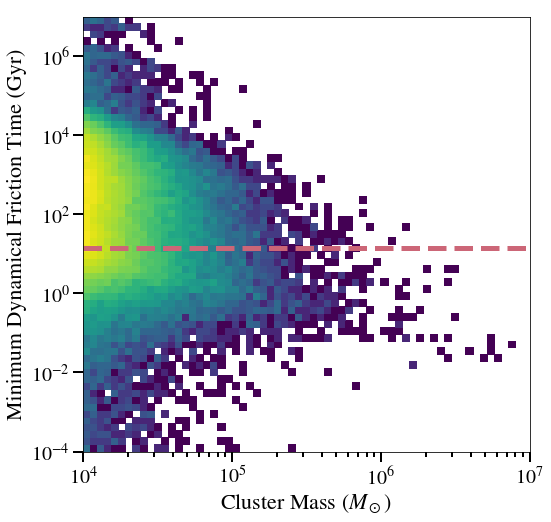

In [26]:
fig = plt.figure( figsize=(8,8), facecolor='w' )
ax = plt.gca()

min_fric_times = np.nanmin( t_friction, axis=1 )
ax.hist2d(
    data_out['ClusterMass'],
    min_fric_times.value,
    bins = [ np.logspace( 4., 7., 64 ), np.logspace( -4., 7., 64 ), ],
    norm = matplotlib.colors.LogNorm(),
)

hubble_time = ( 1. / ( w.hubble_param * 100. * unyt.km / unyt.s / unyt.Mpc ) ).to( 'Gyr' )
ax.axhline(
    hubble_time,
    color = palettable.cartocolors.qualitative.Safe_10.mpl_colors[1],
    linewidth = 5,
    linestyle = '--',
)

ax.set_xlabel( 'Cluster Mass ($M_\odot$)', fontsize=22 )
ax.set_ylabel( 'Minimum Dynamical Friction Time (Gyr)', fontsize=22 )
ax.set_xscale( 'log' )
ax.set_yscale( 'log' )

fig

In [27]:
frac_spiral = ( final_inds != 0 ).sum() / final_inds.size
print( '{:.2g}% of the clusters reach t_DF < t_age'.format( frac_spiral*100 ) )

12% of the clusters reach t_DF < t_age


## Select Valid Clusters to Evolve
This mask selects the subset of clusters that are okay to evolved.
Conditions:
1. Must be in the main halo at z=0 (~90% of clusters fit this criteria)
2. Must not be traced by a particle that splits (~99.95% of clusters fit this criteria)

In [28]:
target_halo_id = 0
in_target_halo_at_z0 = data_out['mt_gal_id'][:,0].astype( int ) == target_halo_id

In [29]:
valid_cluster_to_evolve = in_target_halo_at_z0 & is_not_nan
data_out['ValidCluster'] = valid_cluster_to_evolve

## Finish up and Store the Data

In [30]:
# Assert that all output data has the expected shape
for key, item in data_out.items():
    assert item.shape[0] == id_df.index.size, print( key )

In [31]:
# Save the Data
data_out = verdict.Dict( data_out )
save_file = 'cosmo_histories_{}.hdf5'.format(w.tag )
save_filepath = os.path.join( w.data_dir, save_file )
data_out.to_hdf5( save_filepath, )

print( 'Data saved at {}'.format( save_filepath ) )

Data saved at /scratch/03057/zhafen/linefinder_data/multiphysics/m12i_res7100_mhdcv/data/cosmo_histories_m12imhdcv_clustersofFIRE_pop1.hdf5
